In [4]:
import pandas as pd
import numpy as np

In [5]:
df_raw = pd.read_csv("../data/train_logs.csv")
df_raw.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


**id** - The unique ID of the essay

**event_id** - The index of the event, ordered chronologically

**down_time** - The time of the down event in milliseconds

**up_time** - The time of the up event in milliseconds

**action_time** - The duration of the event (the difference between down_time and up_time)

**activity** - The category of activity which the event belongs to

- **Nonproduction** - The event does not alter the text in any way

- **Input** - The event adds text to the essay

- **Remove/Cut** - The event removes text from the essay

- **Paste** - The event changes the text through a paste input

- **Replace** - The event replaces a section of text with another string

- **Move From [x1, y1] To [x2, y2]** - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

**down_event** - The name of the event when the key/mouse is pressed

**up_event** - The name of the event when the key/mouse is released

**text_change** - The text that changed as a result of the event (if any)

**cursor_position** - The character index of the text cursor after the event

**word_count** - The word count of the essay after the event

In [6]:
# Creating a new df based on the number of essays
# More features (columns) will be added to this df

df = pd.DataFrame({
    'id': df_raw["id"].unique()
})
df.head()

,id
0,001519c8
1,0022f953
2,0042269b
3,0059420b
4,0075873a


In [7]:
# Calculating the final word count for each essay
df_word = df_raw.groupby("id")['word_count'].max()
df = pd.merge(df, df_word, on="id", how="left")

In [8]:
# Turning milliseconds into minutes
df_raw['current_min'] = df_raw["down_time"]//60000

In [9]:
#Counting the number of events per essay
df_event = df_raw.groupby("id")['event_id'].count()

df = pd.merge(df, df_event, on="id", how="left")
df = df.rename(columns={"event_id": "event_count"})

In [10]:
# Calculating the time spend on writing the essay
df_time = df_raw.groupby("id")['current_min'].max()
df = pd.merge(df, df_time, on="id", how="left")
df = df.rename(columns={"current_min": "writing_time_min"})

In [11]:
# Calculating events per minute
df['events_per_min'] = df["event_count"] / df['writing_time_min']

In [12]:
# Calculating the number of TEXT changes made during the writing process
filter_text_change = df_raw["text_change"]!="NoChange"
df_filtered = df_raw[filter_text_change]
df_text_change = df_filtered.groupby("id")['text_change'].count()

df = pd.merge(df, df_text_change, on="id", how="left")

In [13]:
df = df.rename(columns={"text_change": "text_change_count"})

In [14]:
# Calculating text changes per minute
df['text_changes_per_min'] = df["text_change_count"] / df['writing_time_min']

In [15]:
df

,id,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min
0,001519c8,256,2557,30,85.233333,2437,81.233333
1,0022f953,323,2454,29,84.620690,2200,75.862069
2,0042269b,404,4136,29,142.620690,3961,136.586207
3,0059420b,206,1556,23,67.652174,1457,63.347826
4,0075873a,252,2531,27,93.740741,2459,91.074074
...,...,...,...,...,...,...,...
2466,ffb8c745,461,4739,29,163.413793,4550,156.896552
2467,ffbef7e5,438,2604,29,89.793103,2456,84.689655
2468,ffccd6fd,201,3063,32,95.718750,2937,91.781250
2469,ffec5b38,413,3242,25,129.680000,3171,126.840000


In [16]:
#Aleksandra
# Activity column group by activities
# Pauses (total number, per minute, average)

#Yaroslava:
# Number of characters (total in the essay, avg per minute)
# Overtime (yes or no?)
# Average action time

#Ehab
# Most frequent activity
# Average time between events

#Anastastija
# Move From explore futher..
# Number of sentences based on the number of full stops/excl. marks

In [20]:
# If overtime writing (if the writing time exceeded 30 minutes)
df['overtime_writing'] = df['writing_time_min'] > 30

In [21]:
# Average Action Time - average duration of the actions for each essay. 
# Summing the durations of all actions in an essay and then dividing by the total number of actions.
# I leave values in the milliseconds due to it is very short in duration 

total_action_time = df_raw.groupby('id')['action_time'].sum()
df = pd.merge(df, total_action_time, on='id', how='left')

df['average_action_time'] = df['action_time'] / df['event_count']
df = df.drop(columns=['action_time'])


In [22]:
# Total num of characters in the essay, including spaces etc:

# 'Input' and 'Paste' events, count each event as one character added
# "Remove/Cut" event as one character removed.
# I think the "Replace" action does not affect the total character count, as it's essentially a one-for-one substitution.

df_raw['chars_added'] = df_raw['activity'].apply(lambda x: 1 if x in ['Input', 'Paste'] else 0)
df_raw['chars_removed'] = df_raw['activity'].apply(lambda x: 1 if x == 'Remove/Cut' else 0)

total_chars_added = df_raw.groupby('id')['chars_added'].sum()
total_chars_removed = df_raw.groupby('id')['chars_removed'].sum()

df = pd.merge(df, total_chars_added, on='id', how='left')
df = pd.merge(df, total_chars_removed, on='id', how='left')

df['total_characters'] = df['chars_added'] - df['chars_removed']
df.drop(columns=['chars_added', 'chars_removed'], inplace=True)

In [23]:
# Average Characters per Minute - dividion of the total number of characters by the total writing time in minutes
# I left these values in float type, not rounded to the int, to keep the precision, but it can be converted to the int if needed
df['avg_characters_per_min'] = df['total_characters'] / df['writing_time_min']

In [24]:
df

,id,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min,overtime_writing,average_action_time,total_characters,avg_characters_per_min
0,001519c8,256,2557,30,85.233333,2437,81.233333,False,116.246774,1593,53.100000
1,0022f953,323,2454,29,84.620690,2200,75.862069,False,112.221271,1679,57.896552
2,0042269b,404,4136,29,142.620690,3961,136.586207,False,101.837766,3076,106.068966
3,0059420b,206,1556,23,67.652174,1457,63.347826,False,121.848329,1154,50.173913
4,0075873a,252,2531,27,93.740741,2459,91.074074,False,123.943896,1425,52.777778
...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,461,4739,29,163.413793,4550,156.896552,False,105.437856,2628,90.620690
2467,ffbef7e5,438,2604,29,89.793103,2456,84.689655,False,82.266129,2335,80.517241
2468,ffccd6fd,201,3063,32,95.718750,2937,91.781250,True,75.605615,2761,86.281250
2469,ffec5b38,413,3242,25,129.680000,3171,126.840000,False,89.277915,2619,104.760000


# Train labels (essay grades)


In [17]:
df_labels = pd.read_csv("../data/train_scores.csv")
df_labels.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


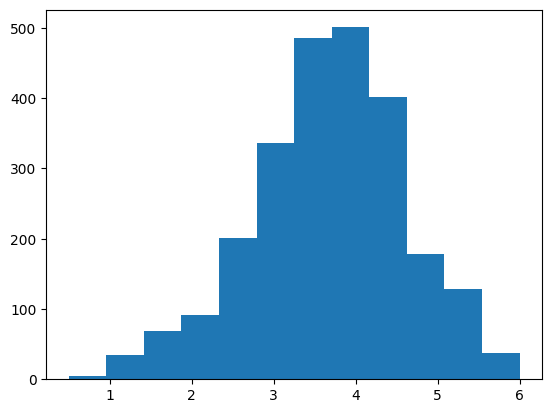

In [18]:
import matplotlib.pyplot as plt

plt.hist(df_labels['score'], bins = 12)
plt.show()

<Axes: xlabel='score'>

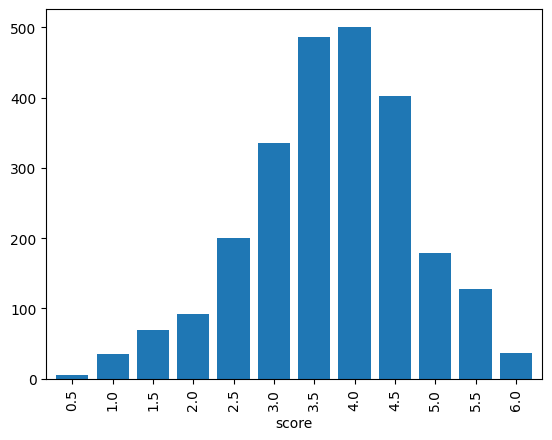

In [19]:
df_labels.groupby('score')['id'].count().plot.bar(width =0.8)